In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
(images,labels),(_,_) = tf.keras.datasets.mnist.load_data()

In [3]:
images.shape , labels.shape

((60000, 28, 28), (60000,))

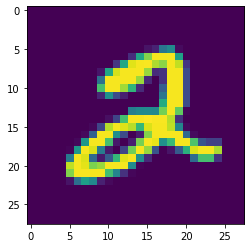

In [4]:
plt.imshow(images[5])

In [5]:
images = images/127.5 -1

In [6]:
images.min() , images.max()

(-1.0, 1.0)

In [7]:
images = np.expand_dims(images,-1)  #用tensorflow方法还要对数据进行转换

In [8]:
images.shape

(60000, 28, 28, 1)

In [9]:
 dataset = tf.data.Dataset.from_tensor_slices((images,labels))

In [10]:
dataset

<TensorSliceDataset shapes: ((28, 28, 1), ()), types: (tf.float64, tf.uint8)>

In [11]:
BATCH_SIZE = 256
noise_dim = 50
con_dim = 50

In [12]:
dataset = dataset.shuffle(60000).batch(BATCH_SIZE)

In [13]:
def generator():
    noise_seed = layers.Input(shape=((noise_dim)))
    label = layers.Input(shape=(()))
    con_seed = layers.Input(shape=((con_dim)))
    
    x = layers.Embedding(10,50,input_length=1)(label)
    x = layers.concatenate([noise_seed,x,con_seed])
    x = layers.Dense(3*3*128,use_bias=False)(x)
    x = layers.Reshape((3,3,128))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(64,(3,3), strides=(2,2),use_bias=False)(x)
    x = layers.BatchNormalization()(x)   #(7,7,,64)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(32,(3,3), strides=(2,2),padding='same',use_bias=False)(x)
    x = layers.BatchNormalization()(x)  #(14,14,32)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(1,(3,3), strides=(2,2),padding='same',use_bias=False)(x)
    x = layers.Activation('tanh')(x)    #（28，28，1）
    
    model = tf.keras.Model(inputs=[noise_seed,label,con_seed], outputs = x)
    
    return model

In [14]:
gen = generator()
gen.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50)           500         input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 50)]         0                                            
______________________________________________________________________________________________

In [15]:
def discriminator():
    image = layers.Input(shape=(28,28,1))
    
    x = layers.Conv2D(32,(3,3),strides=(2,2),padding='same',use_bias=False)(image)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(64,(3,3),strides=(2,2),padding='same',use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(128,(3,3),strides=(2,2),padding='same',use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Flatten()(x)
    
    x1 = layers.Dense(1)(x)   #真假输出
    x2 = layers.Dense(10)(x)  #分类输出
    x3 = layers.Dense(con_dim)(x)  #condition输出即还原c
    
    model = tf.keras.Model(inputs=image, outputs = [x1,x2,x3])
    
    return model

In [16]:
disc = discriminator()
disc.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   288         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 14, 14, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 14, 14, 32)   0           batch_normalization_3[0][0]      
____________________________________________________________________________________________

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [18]:
def discriminator_loss(real_out,real_cls_out,fake_out,label,con_out,con_in):
    
    #这里希望让真实图像被判定为1,假的图像判定为0
    real_loss = cross_entropy(tf.ones_like(real_out),real_out)
    fake_loss = cross_entropy(tf.zeros_like(fake_out),fake_out)
    cat_loss = cce(label,real_cls_out)
    con_loss = tf.reduce_mean(tf.square(con_out - con_in))  #平方误差
    
    return real_loss + fake_loss + cat_loss + con_loss

In [19]:
#生成器接收假的的图片并希望能够被判为真
def generator_loss(fake_out,fake_cls_out,label,con_out,con_in):
    fake_loss = cross_entropy(tf.ones_like(fake_out),fake_out)
    cat_loss = cce(label,fake_cls_out)
    con_loss = tf.reduce_mean(tf.square(con_out - con_in))  #平方误差
    return fake_loss + cat_loss + con_loss

    
    

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)   #创建优化器

In [21]:
@tf.function
def train_step(image,label):
    size = label.shape[0]
    noise = tf.random.normal([size,noise_dim])
    cond = tf.random.normal([size,con_dim])
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
         
        gen_image = gen((noise,cond,label),training=True)
        fake_out,fake_cls_out,con_out = disc(gen_image,training=True)
        real_out,real_cls_out, _ = disc(image,training=True)
         
        gen_loss = generator_loss(fake_out,fake_cls_out,label,con_out,cond)
        disc_loss = discriminator_loss(real_out,real_cls_out,fake_out,label,con_out,cond)
        
    gradient_gen = gen_tape.gradient(gen_loss,gen.trainable_variables)
    gradient_disc = disc_tape.gradient(disc_loss,disc.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradient_gen,gen.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_disc,disc.trainable_variables))
    

In [22]:
#画出这一个批次的图片
def generate_plot_image(model, noise, label,epoch_num,cond):
    print('Epoch:',epoch_num)
    # cond = tf.random.normal([size,con_dim])
    gen_image = model((noise,cond,label),training=False)
    gen_image = tf.squeeze(gen_image)  #(28,28,1) -->(None,28,28)
    fig = plt.figure(figsize=(10,1))
    for i in range(gen_image.shape[0]):
        plt.subplot(1,10,i+1)   #1行10列
        #因为在生成图片最后用激活函数tanh把图片映射到[-1,1]之间,现在要把取值范围改变成[0,1]的范围
        plt.imshow((gen_image[i,:,:] + 1)/ 2)
        plt.axis('off')    #不用显示坐标
    plt.show()

In [23]:
num = 10
noise_seed = tf.random.normal([num,noise_dim])
label_seed = np.random.randint(0,10,size=(num))
print(label_seed.T)


[4 6 1 5 9 4 0 7 5 3]


In [24]:
def train(dataset,epochs):
    for epoch in range(epochs):
        for image_bath ,label_batch in dataset:
            train_step(image_bath,label_batch)
        if epoch%10 ==0:
            cond = tf.random.normal([size,con_dim])
            generate_plot_image(gen,noise_seed,label_seed,epoch,cond)
    cond = tf.random.normal([size,con_dim])    
    generate_plot_image(gen,noise_seed,label_seed,epoch,cond)   
           

In [25]:
EPOCHES = 200

In [26]:
train(dataset,EPOCHES)

TypeError: in converted code:

    <ipython-input-21-5fcef9b02640>:8 train_step  *
        gen_image = gen((noise,cond,label),training=True)
    A:\Anaconda\envs\kr\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py:847 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    A:\Anaconda\envs\kr\lib\site-packages\tensorflow_core\python\keras\engine\network.py:708 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    A:\Anaconda\envs\kr\lib\site-packages\tensorflow_core\python\keras\engine\network.py:860 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    A:\Anaconda\envs\kr\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py:847 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    A:\Anaconda\envs\kr\lib\site-packages\tensorflow_core\python\keras\layers\merge.py:182 call
        return self._merge_function(inputs)
    A:\Anaconda\envs\kr\lib\site-packages\tensorflow_core\python\keras\layers\merge.py:394 _merge_function
        return K.concatenate(inputs, axis=self.axis)
    A:\Anaconda\envs\kr\lib\site-packages\tensorflow_core\python\keras\backend.py:2708 concatenate
        return array_ops.concat([to_dense(x) for x in tensors], axis)
    A:\Anaconda\envs\kr\lib\site-packages\tensorflow_core\python\util\dispatch.py:180 wrapper
        return target(*args, **kwargs)
    A:\Anaconda\envs\kr\lib\site-packages\tensorflow_core\python\ops\array_ops.py:1431 concat
        return gen_array_ops.concat_v2(values=values, axis=axis, name=name)
    A:\Anaconda\envs\kr\lib\site-packages\tensorflow_core\python\ops\gen_array_ops.py:1257 concat_v2
        "ConcatV2", values=values, axis=axis, name=name)
    A:\Anaconda\envs\kr\lib\site-packages\tensorflow_core\python\framework\op_def_library.py:499 _apply_op_helper
        raise TypeError("%s that don't all match." % prefix)

    TypeError: Tensors in list passed to 'values' of 'ConcatV2' Op have types [float32, float32, uint8] that don't all match.
